In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
from lib import DihedralAdherencePDB
import os
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns

PDBMINE_URL = os.getenv("GREEN_PDBMINE_URL")
PROJECT_DIR = 'ml_data'

pdb_codes = [f.name.split('_')[0] for f in Path(PROJECT_DIR).iterdir() if f.is_dir()]

In [73]:
da = DihedralAdherencePDB(
    pdb_codes[0], [4,5,6,7], PDBMINE_URL, PROJECT_DIR, mode='full_window',
    kdews=[0, 1, 0, 0]
)
da.load_results()

Results already exist
Structure exists: 'pdb/pdb5sj7.ent' 
UniProt ID: Q9Y233


True

In [67]:
center_idx_ctxt = da.queries[-1].get_center_idx_pos()
winsize_ctxt = da.queries[-1].winsize
seqs_for_window = da.seqs[center_idx_ctxt:-(winsize_ctxt - center_idx_ctxt - 1)]

In [74]:
da.queries = da.queries[1:]
da.winsizes = da.winsizes[1:]

In [56]:
da.queries[-1].results[da.queries[-1].results.seq.str.contains('IRGEE')]

,seq,res,phi,psi,chain,protein_id,weight
151456,KVIRGEE,R,-106.3,21.2,A,2O8H,1
151457,KVIRGEE,R,-79.7,3.8,A,2OUN,1
151458,KVIRGEE,R,-75.5,-0.5,B,2OUN,1
151459,KVIRGEE,R,-79.5,1.1,A,2OUP,1
151460,KVIRGEE,R,-77.6,-7.1,B,2OUP,1
...,...,...,...,...,...,...,...
152643,IRGEETA,E,-80.2,-17.3,B,5SJU,1
152644,IRGEETA,E,-95.8,-12.8,C,5SJU,1
152645,IRGEETA,E,-89.3,-17.7,A,5SK8,1
152646,IRGEETA,E,-100.1,7.3,A,6MSA,1


In [55]:
# da.queries[0].results.groupby('seq').count().sort_values('res', ascending=False).head(30).sort_values('res')
da.queries[0].results.groupby('seq').count().sort_values('res').head(50).iloc[::-1].head(10)

,res,phi,psi,chain,protein_id,weight
seq,,,,,,
VRLCK,1152,1152,1152,1152,1152,1152
CKEIE,1143,1143,1143,1143,1143,1143
MQFTL,1139,1139,1139,1139,1139,1139
LMQFT,1137,1137,1137,1137,1137,1137
VIRGE,1051,1051,1051,1051,1051,1051
GEETA,985,985,985,985,985,985
GLMQF,979,979,979,979,979,979
IRGEE,876,876,876,876,876,876
QGLMQ,531,531,531,531,531,531


In [79]:
da.pdb_code

'5SJ7'

	Win 5: VIRGE - 1051 samples
	Win 6: VIRGEE - 818 samples
	Win 7: KVIRGEE - 813 samples
Number of clusters: 4
(919, 10)
Cluster 0 has 820 members and medoid [-56.2 -62.7 -79.2  70.7 -83.5 -46.2 -38.8   4.8  16.   -9.7]
Cluster 1 has 21 members and medoid [-120.6 -108.7   56.    79.3  -95.2  108.9  114.2   42.4   -8.   126.2]
Cluster 2 has 26 members and medoid [-137.6 -116.9  -60.   -77.   -85.4 -173.   144.6  -27.3  -65.2  156.2]
Cluster 3 has 52 members and medoid [-122.7 -112.7  -66.5  -94.9 -106.8  126.3  134.   117.5 -131.   -31.5]


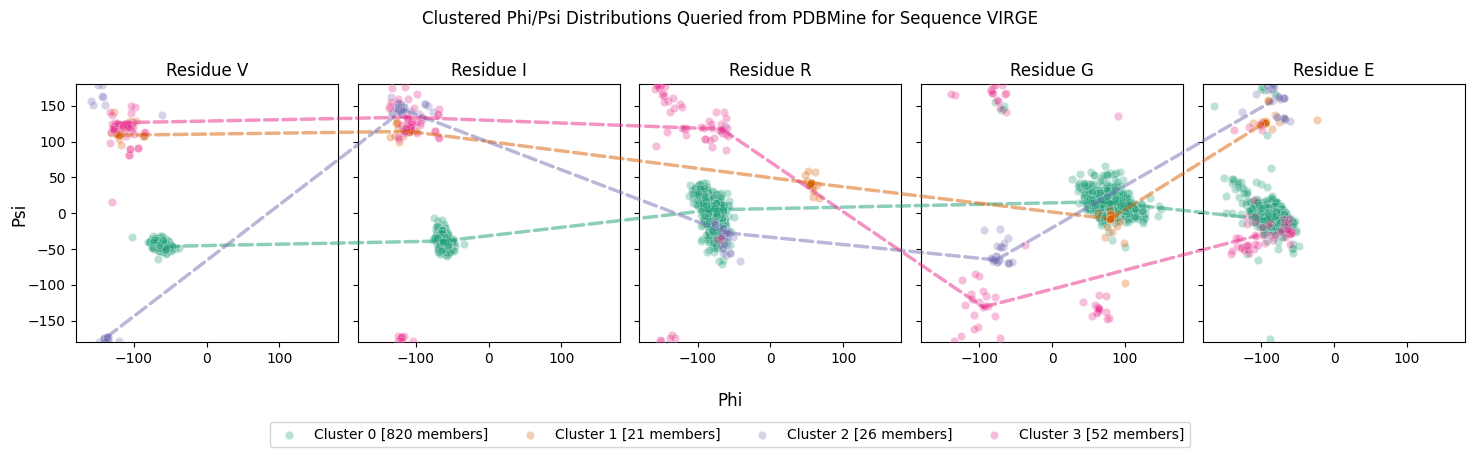

In [76]:
# da.plot_across_window_cluster_medoids(seqs_for_window[15], verbose=True)
da.plot_across_window_cluster_medoids('KVIRGEE', verbose=True, mode_scatter=True)

In [227]:
da = DihedralAdherencePDB(
    pdb_code, [4,5,6,7], PDBMINE_URL, PROJECT_DIR, mode='full_window_ml',
    kdews=[1, 1, 1, 1], weights_file='ml_runs/trans_d32_blocks1.pt'
)
da.load_results()

Results already exist
Structure exists: 'pdb/pdb6f9v.ent' 
UniProt ID: P12821


True

In [ ]:
results = []
for pdb_code in pdb_codes[0:150]:
    da = DihedralAdherencePDB(
        pdb_code, [4,5,6,7], PDBMINE_URL, PROJECT_DIR, mode='full_window_ml',
        kdews=[1, 1, 1, 1], weights_file='ml_runs/trans_d32_blocks1.pt', device='cuda:0'
    )
    if not da.load_results():
        continue
    try:
        da.compute_das(replace=False)
    except ValueError:
        continue
    results.append(da.results)
results = pd.concat(results, axis=0).reset_index(drop=True)

In [ ]:
# da = DihedralAdherencePDB(
#     pdb_codes[0], [4,5,6,7], PDBMINE_URL, PROJECT_DIR, mode='ml',
#     weights_file='ml_runs/best_model-kde_16-32_383.pt', device='cuda'
# )
# results = []
for pdb_code in pdb_codes[50:150]:
    da = DihedralAdherencePDB(
        pdb_code, [4,5,6,7], PDBMINE_URL, PROJECT_DIR, mode='kde',
        kdews=[0, 0, 0, 1]
    )
    da.load_results()
    da.compute_das()
#     results.append(da.results)
# results = pd.concat(results, axis=0).reset_index(drop=True)

In [ ]:
results = []
for pdb_code in pdb_codes[:150]:
    if not Path(f'{PROJECT_DIR}/{pdb_code}_win4-5-6-7/xray_phi_psi_da.csv').exists():
        continue
    da = DihedralAdherencePDB(
        pdb_code, [4,5,6,7], PDBMINE_URL, PROJECT_DIR, mode='kde',
        kdews=[0, 0, 0, 1]
    )
    da.load_results_da()
    results.append(da.results)
results = pd.concat(results, axis=0).reset_index(drop=True)

In [27]:
da = DihedralAdherencePDB(
    pdb_codes[12], [4,5,6,7], PDBMINE_URL, PROJECT_DIR, mode='kde',
    kdews=[1, 1, 1, 1], weights_file='ml_runs/trans_d32_blocks1.pt', device='cuda:0'
)
da.load_results_da()
da.results

Results already exist
Structure exists: 'pdb/pdb2xne.ent' 
UniProt ID: O14965


,Model,GDT_TS,RMS_CA,DA
0,2XNE,0.953061,2.714545,0.768405


In [29]:
da = DihedralAdherencePDB(
    pdb_codes[12], [4,5,6,7], PDBMINE_URL, PROJECT_DIR, mode='full_window_ml',
    kdews=[1, 1, 1, 1], weights_file='ml_runs/trans_d32_blocks1.pt', device='cuda:0'
)
da.load_results_da()
da.results

Results already exist
Structure exists: 'pdb/pdb2xne.ent' 
UniProt ID: O14965


,Model,GDT_TS,RMS_CA,DA
0,2XNE,0.953061,2.714545,0.928297


In [34]:
np.log10(da.xray_phi_psi.da.sum())

3.4756857922808404

In [ ]:
results = []
xrays = []
for pdb_code in pdb_codes[:150]:
    if not Path(f'{PROJECT_DIR}/{pdb_code}_win4-5-6-7/xray_phi_psi_da_window_ml.csv').exists():
        continue
    da = DihedralAdherencePDB(
        pdb_code, [4,5,6,7], PDBMINE_URL, PROJECT_DIR, mode='full_window_ml',
        kdews=[1, 1, 1, 1], weights_file='ml_runs/trans_d32_blocks1.pt', device='cuda:0'
    )
    da.load_results_da()
    results.append(da.results)
    xrays.append(np.log10(da.xray_phi_psi.da.sum()))
xrays = np.array(xrays)
results = pd.concat(results, axis=0).reset_index(drop=True)

In [39]:
results_copy = results.copy()

<Axes: ylabel='Density'>

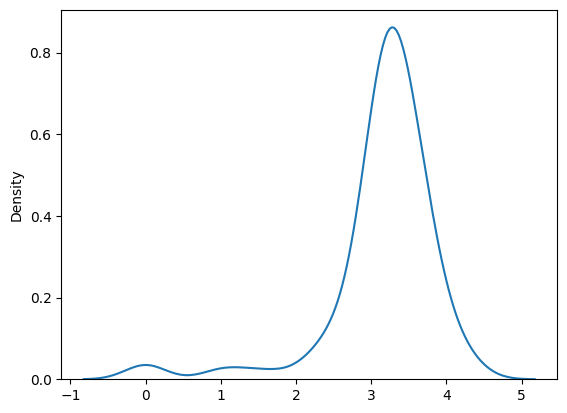

In [52]:
sns.kdeplot(xrays)

In [50]:
results['DA'] = results['DA'] - 3.15

0.05983191718014685

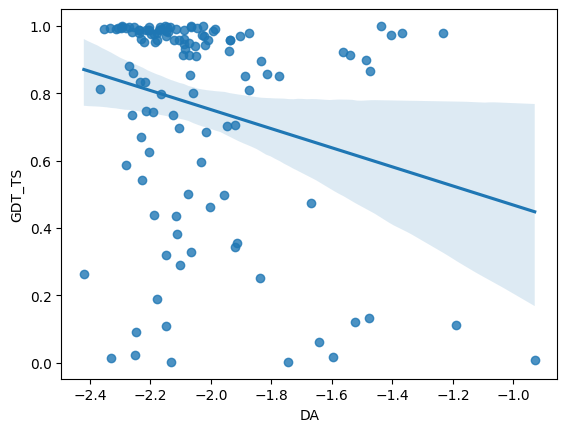

In [51]:
import matplotlib.pyplot as plt
from scipy.stats import linregress
col = 'GDT_TS'
reg = linregress(results.dropna()['DA'], results.dropna()[col])
sns.regplot(x='DA', y=col, data=results.reset_index(drop=True))
reg.rvalue**2

In [4]:
da = DihedralAdherencePDB(
    pdb_codes[0], [4,5,6,7], PDBMINE_URL, PROJECT_DIR, mode='kde',
    kdews=[0, 0, 0, 1]
)
da.load_results_da()

Results already exist
Structure exists: 'pdb/pdb2rj7.ent' 
UniProt ID: P16442


In [146]:
from lib import DihedralAdherence
da = DihedralAdherence(
    'T1024', [4,5,6,7], PDBMINE_URL, 'casp_da', mode='kde',
    kdews=[0, 0, 0, 1]
)

Initializing T1024 ...
casp_da/T1024_win4-5-6-7
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 
UniProt ID: Q48658


In [147]:
from Bio.PDB import Superimposer, PDBParser
import warnings
from Bio.Align import PairwiseAligner
from lib.constants import AMINO_ACID_CODES
import numpy as np

def get_aligned_atoms(fnA, fnB, startA=None, endA=None, startB=None, endB=None, print_alignment=True):
    # Compute RMSD between two structures
    pdb_parser = PDBParser()
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        structureA = pdb_parser.get_structure('', fnA)
        structureB = pdb_parser.get_structure('', fnB)
    
    chainA = next(iter(structureA[0].get_chains()))
    chainB = next(iter(structureB[0].get_chains()))

    startA = startA or 0
    endA = endA or len(chainA)
    startB = startB or 0
    endB = endB or len(chainB)

    residuesA = ''.join([AMINO_ACID_CODES.get(r.resname, 'X') for r in chainA.get_residues()])[startA:endA]
    residuesB = ''.join([AMINO_ACID_CODES.get(r.resname, 'X') for r in chainB.get_residues()])[startB:endB]
    aligner = PairwiseAligner()
    aligner.mode = 'global'
    alignments =  aligner.align(residuesA, residuesB)
    if print_alignment:
        print(alignments[0])

    atomsA = []
    atomsB = []
    residuesA = list(chainA.get_residues())[startA:endA]
    residuesB = list(chainB.get_residues())[startB:endB]
    for i,((t1,t2),(q1,q2)) in enumerate(zip(*alignments[0].aligned)):
        for j, (residueA, residueB) in enumerate(zip(residuesA[t1:t2], residuesB[q1:q2])):
            if residueA.resname != residueB.resname:
                print(f'WARNING: Residues {residueA.resname} and {residueB.resname} don\'t match at position: {j}')
            try:
                atomA = residueA['CA']
                atomB = residueB['CA']
            except KeyError:
                print(f'WARNING: Atom "CA" missing at position: {i}')
                continue
            if atomB is None or atomA is None:
                print(f'WARNING: Atom "CA" missing at position: {i}')
                continue
            atomsA.append(atomA)
            atomsB.append(atomB)
    return atomsA, atomsB

def compute_rmsd(fnA, fnB, startA=None, endA=None, startB=None, endB=None, print_alignment=True, return_n=False):
    atomsA, atomsB = get_aligned_atoms(fnA, fnB, startA, endA, startB, endB, print_alignment)

    sup = Superimposer()
    sup.set_atoms(atomsA, atomsB)
    sup.apply(atomsB)
    if return_n:
        atomsA = np.array([a.coord for a in atomsA])
        atomsB = np.array([a.coord for a in atomsB])
        dist = np.sum((atomsA - atomsB)**2)
        return sup.rms, len(atomsA), dist
    return sup.rms

def compute_gdt(fnA, fnB, startA=None, endA=None, startB=None, endB=None, print_alignment=True, return_n=False, thresholds=[1,2,4,8]):
    atomsA, atomsB = get_aligned_atoms(fnA, fnB, startA, endA, startB, endB, print_alignment)

    sup = Superimposer()
    sup.set_atoms(atomsA, atomsB)
    sup.apply(atomsB)
    atomsA = np.array([a.coord for a in atomsA])
    atomsB = np.array([a.coord for a in atomsB])
    n = atomsA.shape[0]

    dist = np.linalg.norm(atomsA - atomsB, axis=1)
    gdt = []
    for t in thresholds:
        gdt.append((dist <= t).sum() / n)
    return np.mean(gdt)

af_fn = da.predictions_dir / 'T1030TS427_4'
print(compute_rmsd(da.xray_fn, af_fn, print_alignment=False))
compute_gdt(da.xray_fn, af_fn, print_alignment=False)

FileNotFoundError: [Errno 2] No such file or directory: 'casp-predictions/T1024/T1030TS427_4'

In [156]:
gdts = []
rmsds = []
for i,row in da.results.iterrows():
    fn = row['Model']
    gdt = compute_gdt(da.xray_fn, da.predictions_dir / fn, print_alignment=False)
    rmsd = compute_rmsd(da.xray_fn, da.predictions_dir / fn, print_alignment=False)
    gdts.append(gdt)
    rmsds.append(rmsd)
da.results['GDT2'] = gdts
da.results['RMSD2'] = rmsds
da.results['GDT2'] = da.results['GDT2'] * 100

<Axes: >

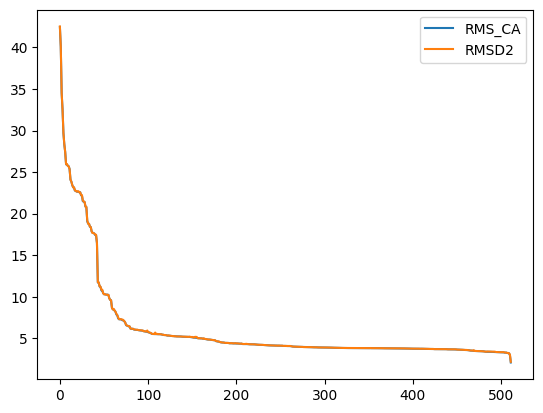

In [158]:
# da.results[['GDT_TS', 'GDT2']].plot()
da.results[['RMS_CA', 'RMSD2']].sort_values('RMS_CA', ascending=False).reset_index(drop=True).plot()

<Axes: >

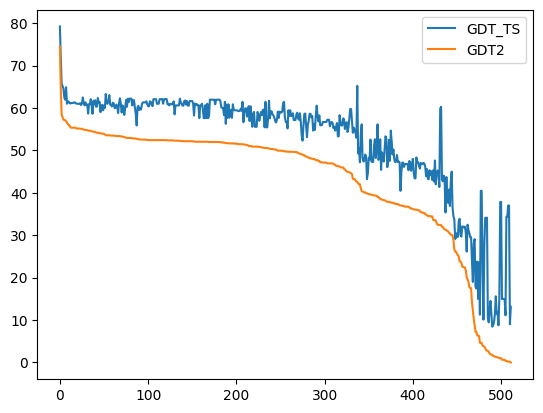

In [154]:
da.results[['GDT_TS', 'GDT2']].sort_values('GDT2', ascending=False).reset_index(drop=True).plot()